<a href="https://colab.research.google.com/github/stremerfort/pyscf/blob/main/pyscf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install pyscf
!pip install pyscf py3Dmol
!pip install rdkit
!pip install fortecubeview
!pip install fortecubeview
!pip install pythreejs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.7/271.7 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.9 MB/s eta 0:00:00


In [40]:
import pathlib

# RDKit imports:
from rdkit import Chem
from rdkit.Chem import (
    AllChem,
    rdCoordGen,
)
from rdkit.Chem.Draw import IPythonConsole

IPythonConsole.ipython_useSVG = True  # Use higher quality images for molecules

# For visualization of molecules and orbitals:
import py3Dmol
import fortecubeview

# pyscf imports:
from pyscf import gto, scf, lo, tools

# For plotting
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_theme(style="ticks", context="talk", palette="muted")

# For numerics:
import numpy as np
import pandas as pd

pd.options.display.float_format = "{:,.3f}".format
#guardar en github
from getpass import getpass
import subprocess

Set up the molecule with RDKit

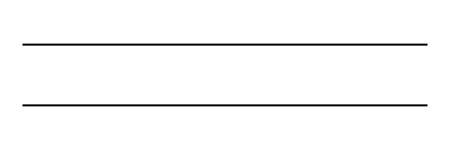

In [18]:
molecule_name = "ethene"
molecule = Chem.MolFromSmiles("C=C")  # Generate the molecule from smiles
molecule

In [19]:
def get_xyz(molecule, optimize=False):
    """Get xyz-coordinates for the molecule"""
    mol = Chem.Mol(molecule)
    mol = AllChem.AddHs(mol, addCoords=True)
    AllChem.EmbedMolecule(mol)
    if optimize:  # Optimize the molecules with the MM force field:
        AllChem.MMFFOptimizeMolecule(mol)
    xyz = []
    for lines in Chem.MolToXYZBlock(mol).split("\n")[2:]:
        strip = lines.strip()
        if strip:
            xyz.append(strip)
    xyz = "\n".join(xyz)
    return mol, xyz

In [20]:
molecule3d, xyz = get_xyz(molecule)

In [21]:
view = py3Dmol.view(
    data=Chem.MolToMolBlock(molecule3d),
    style={"stick": {}, "sphere": {"scale": 0.3}},
    width=300,
    height=300,
)
view.zoomTo()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Run pyscf and calculate molecular orbitals

In [22]:
def run_calculation(xyz, basis="sto-3g"):
    """Calculate the energy (+ additional things like MO coefficients) with pyscf."""
    mol = gto.M(
        atom=xyz,
        basis=basis,
        unit="ANG",
        symmetry=True,
    )
    mol.build()
    mf = scf.RHF(mol).run()
    return mf, mol

In [23]:
mf, mol = run_calculation(xyz, basis="sto-3g")

converged SCF energy = -77.0658317442502


In [24]:
table = pd.DataFrame({"Energy": mf.mo_energy, "Occupancy": mf.mo_occ})
table

,Energy,Occupancy
0,-11.016,2.000
1,-11.015,2.000
2,-0.976,2.000
3,-0.737,2.000
4,-0.613,2.000
5,-0.511,2.000
6,-0.470,2.000
7,-0.318,2.000
8,0.315,0.000
9,0.653,0.000


Let us also make a plot of the energy levels:

<ipython-input-25-50c7e0e14e1f>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = matplotlib.cm.get_cmap("tab20")(np.linspace(0, 1, len(mf.mo_energy)))


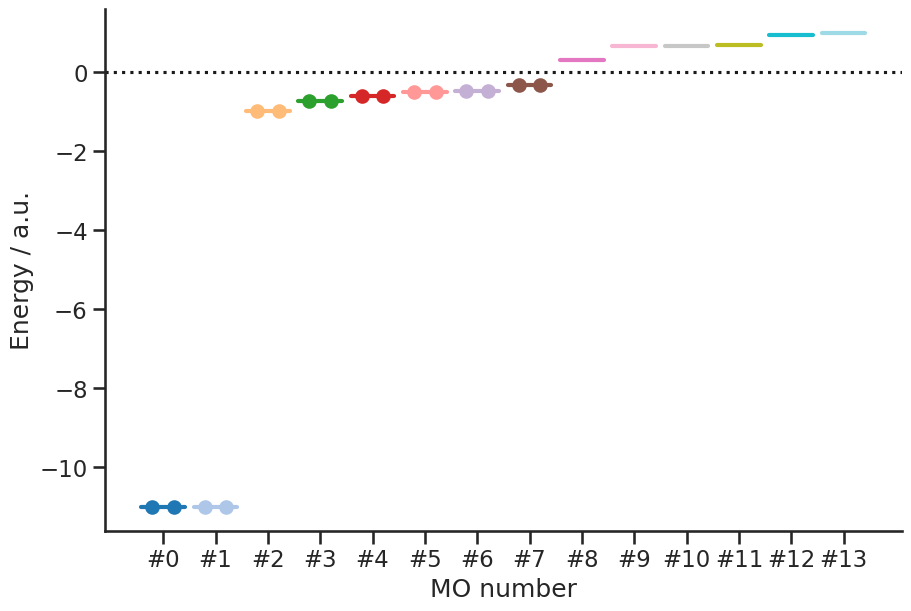

In [25]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(9, 6))
colors = matplotlib.cm.get_cmap("tab20")(np.linspace(0, 1, len(mf.mo_energy)))

pos = []
for i, (energy, occ) in enumerate(zip(mf.mo_energy, mf.mo_occ)):
    left = 3 * i
    right = 3 * i + 2.5
    length = right - left

    (line,) = ax.plot([left, right], [energy, energy], color=colors[i], lw=3)

    electron_x, electron_y = None, None
    if occ == 2:
        electron_x = [left + 0.25 * length, left + 0.75 * length]
        electron_y = [energy, energy]
    elif occ == 1:
        electron_x, electron_y = [left + 0.5], [energy]
    if electron_x and electron_y:
        ax.scatter(electron_x, electron_y, color=line.get_color())

    pos.append(left + 0.5 * length)

ax.axhline(y=0, ls=":", color="k")
ax.set_xticks(pos)
ax.set_xticklabels([f"#{i}" for i, _ in enumerate(pos)])
ax.set(xlabel="MO number", ylabel="Energy / a.u.")
sns.despine(fig=fig)

In [26]:
def get_mo(mf, mol):
    """Get molecular orbitals"""
    orbitals = {"canonical": mf.mo_coeff}

    # Get intrinsic bonding orbitals and localized intrinsic valence virtual orbitals (livvo):
    orbocc = mf.mo_coeff[:, 0 : mol.nelec[0]]
    orbvirt = mf.mo_coeff[:, mol.nelec[0] :]

    ovlpS = mol.intor_symmetric("int1e_ovlp")

    iaos = lo.iao.iao(mol, orbocc)
    iaos = lo.orth.vec_lowdin(iaos, ovlpS)
    ibos = lo.ibo.ibo(mol, orbocc, locmethod="IBO")
    orbitals["ibo"] = ibos

    livvo = lo.vvo.livvo(mol, orbocc, orbvirt)
    orbitals["livvo"] = livvo
    return orbitals

In [27]:
orbitals = get_mo(mf, mol)

 Iterative localization: IB/P4/2x2, 7 iter; Final gradient 1.05e-09
 Iterative localization: IB/P4/2x2, 6 iter; Final gradient 1.08e-09


Visualizing the orbitals with py3Dmol and fortecubeview

In [28]:
def write_all_coeffs(
    mol, coeffs, prefix="cmo", dirname=".", margin=5, offset=0
):
    """Write cube files for the given coefficients."""
    path = pathlib.Path(dirname)
    path.mkdir(parents=True, exist_ok=True)

    for i in range(coeffs.shape[1]):
        outfile = f"{prefix}_{i+offset:02d}.cube"
        outfile = path / outfile
        print(f"Writing {outfile}")
        tools.cubegen.orbital(mol, outfile, coeffs[:, i], margin=margin)

To write all the canonical molecular orbitals write_all_coeffs can be used as follows:

In [29]:
# write_all_coeffs(
#    mol,
#    orbitals["canonical"],
#    prefix=f"{molecule_name}_cmo",
#    dirname="cmo",
#    margin=5,
# )

And to write all the IBOs and LIVVOs:

In [30]:
# write_all_coeffs(
#    mol,
#    orbitals["ibo"],
#    prefix=f"{molecule_name}_ibo",
#    dirname="ibo",
#    margin=5,
# )

# write_all_coeffs(
#    mol,
#    orbitals["livvo"],
#    prefix=f"{molecule_name}_livvo",
#    dirname="ibo",
#    margin=5,
#    offset=orbitals["ibo"].shape[1],
# )

For simplicity, I will only write the highest occupied orbital and the lowest unoccupied orbital here:

In [31]:
def find_homo_lumo(mf):
    lumo = float("inf")
    lumo_idx = None
    homo = -float("inf")
    homo_idx = None
    for i, (energy, occ) in enumerate(zip(mf.mo_energy, mf.mo_occ)):
        if occ > 0 and energy > homo:
            homo = energy
            homo_idx = i
        if occ == 0 and energy < lumo:
            lumo = energy
            lumo_idx = i

    return homo, homo_idx, lumo, lumo_idx


_, homo_idx, _, lumo_idx = find_homo_lumo(mf)
print(f"HOMO (index): {homo_idx}")
print(f"LUMO (index): {lumo_idx}")

HOMO (index): 7
LUMO (index): 8


In [32]:
tools.cubegen.orbital(
    mol, "cmo_homo.cube", orbitals["canonical"][:, homo_idx], margin=5
)
tools.cubegen.orbital(
    mol, "cmo_lumo.cube", orbitals["canonical"][:, lumo_idx], margin=5
)
tools.cubegen.orbital(mol, "ibo_homo.cube", orbitals["ibo"][:, -1], margin=5)
tools.cubegen.orbital(
    mol, "livvo_lumo.cube", orbitals["livvo"][:, 0], margin=5
);

To display the molecular orbitals, fortecubeview is really convenient as we can give it a directory, and it will load all the cube files in that directory:

In [33]:
fortecubeview.plot(path=".", sumlevel=0.85)

CubeViewer: listing cube files from the directory .
Reading 4 cube files


HTML(value='\n        <style>\n           .jupyter-widgets-output-area .output_scroll {\n                heigh…

interactive(children=(Select(description='Cube files:', options=('./cmo_homo.cube', './cmo_lumo.cube', './ibo_…

We can also use py3Dmol. First, we read the cube file we want, and then we pass that to py3Dmol:

data = None

In [34]:
data = None
with open("ibo_homo.cube", "r") as infile:
    data = infile.read()

In [36]:
view = py3Dmol.view()
view.addVolumetricData(
    data,
    "cube",
    {
        "isoval": 0.05,
        "smoothness": 5,
        "opacity": 0.8,
        "volformat": "cube",
        "color": "blue",
    },
)
view.addVolumetricData(
    data,
    "cube",
    {
        "isoval": -0.05,
        "smoothness": 5,
        "opacity": 0.8,
        "volformat": "cube",
        "color": "orange",
    },
)
view.addModel(data, "cube")
view.setStyle({"stick": {}})
view.zoomTo()
view.show()